<a href="https://colab.research.google.com/github/AdityaSrinivasManohar/ROB-535-Perceprtion-Project/blob/main/535_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 535 Perception Project 
**Team 8**

**Members -**
*   Aditya Srinivas Manohar
*   Kavan Nishith Shah
*   Maithili Jagadishchandra Shetty
*   Manikandan Pandiyan 
*   Mohamad Louai Shehab 
*   Theodor Chakhachiro

Please follow the steps as shown below to run the nueral network



# Step 1
In your google drive, create a folder named **yolov4**
To save the trained weights create another folder called **training** inside the yolov4 folder

# Step 2
Run the below code block to mount your google drive, and navigate to the yolov4 folder

In [ ]:
#To mount your google drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# links the path  /content/gdrive/My\ Drive/ to /mydrive so that it can easily be accesed
!ln -s /content/gdrive/My\ Drive/ /mydrive

# list the contents of /mydrive
!ls /mydrive

#Navigate to the yolov4 folder
%cd /mydrive/yolov4

# Step 3
As mentioned in the report we will be using the yolov4 framework to train our network!

To do so we need to clone the darknet repository hosted on github

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

# Step 4
To run yolov4 on a custom dataset we need the following files


1.   The **labelled custom dataset**
2.   **Custom cfg file**
3.   **obj.data** and **obj.names** files
4.   **train.txt** and **test.txt** files for training
5.   Place the above files in the correct directories


# Step 4.1


Download the complete dataset from [Google Drive](https://drive.google.com/drive/folders/15LPTXADcZGv0ZE262yqdwFHDTnP_R_Bx?usp=sharing)

Yolov4 requires each **.jpg image** to have a corresponding **.txt file** with the object number and object coordinates of the image in 1 line as shown below
```
<object-class> <x_center> <y_center> <width> <height>
```
Where:
*   `<object-class>` - integer object number from 0 to 2 (in our case)
*   `<x_center> <y_center> <width> <height>` - float values relative to width and height of image, it can be equal from (0.0 to 1.0]
*   for example: `<x> = <absolute_x> / <image_width>` or `<height> = <absolute_height> / <image_height>`
*   `<x_center> <y_center>` - are center of rectangle (are not top-left corner)

The following code generates a .txt file for every image in such a format from the given data

In [ ]:
import csv
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def rot(n):
    n = np.asarray(n).flatten()
    assert(n.size == 3)

    theta = np.linalg.norm(n)
    if theta:
        n /= theta
        K = np.array([[0, -n[2], n[1]], [n[2], 0, -n[0]], [-n[1], n[0], 0]])

        return np.identity(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
    else:
        return np.identity(3)


def get_bbox(p0, p1):
    """
    Input:
    *   p0, p1
        (3)
        Corners of a bounding box represented in the body frame.

    Output:
    *   v
        (3, 8)
        Vertices of the bounding box represented in the body frame.
    *   e
        (2, 14)
        Edges of the bounding box. The first 2 edges indicate the `front` side
        of the box.
    """
    v = np.array([
        [p0[0], p0[0], p0[0], p0[0], p1[0], p1[0], p1[0], p1[0]],
        [p0[1], p0[1], p1[1], p1[1], p0[1], p0[1], p1[1], p1[1]],
        [p0[2], p1[2], p0[2], p1[2], p0[2], p1[2], p0[2], p1[2]]
    ])
    e = np.array([
        [2, 3, 0, 0, 3, 3, 0, 1, 2, 3, 4, 4, 7, 7],
        [7, 6, 1, 2, 1, 2, 4, 5, 6, 7, 5, 6, 5, 6]
    ], dtype=np.uint8)

    return v, e

classes = (
    'Unknown', 'Compacts', 'Sedans', 'SUVs', 'Coupes',
    'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    'Boats', 'Helicopters', 'Planes', 'Service', 'Emergency',
    'Military', 'Commercial', 'Trains'
)

files = glob('/content/drive/MyDrive/ROB535/trainval/*/*_image.jpg')
Unknown = ['Unknown','Boats', 'Helicopters', 'Planes', 'Service', 'Emergency','Military', 'Commercial', 'Trains']
first = ['Compacts', 'Sedans', 'SUVs', 'Coupes','Muscle', 'SportsClassics', 'Sports', 'Super']
second = ['Motorcycles','OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles']

for idx in range(0,len(files)):
  snapshot = files[idx]
  #print(idx)
  img = plt.imread(snapshot)
  xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
  xyz = xyz.reshape([3, -1])

  proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
  proj.resize([3, 4])

  textfile = snapshot.replace('_image.jpg', '_image.txt')
  f= open(textfile,"w+")

  try:
      bbox = np.fromfile(snapshot.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
  except FileNotFoundError:
      print('[*] bbox not found.')
      bbox = np.array([], dtype=np.float32)
  bbox = bbox.reshape([-1, 11])

  #fig1 = plt.figure(1, figsize=(16, 9))
  #ax1 = fig1.add_subplot(1, 1, 1)
  #ax1.imshow(img)

  colors = ['C{:d}'.format(i) for i in range(10)]
  ptsx =[]
  ptsy =[]
  for k, b in enumerate(bbox):
      R = rot(b[0:3])
      t = b[3:6]

      sz = b[6:9]
      vert_3D, edges = get_bbox(-sz / 2, sz / 2)
      vert_3D = R @ vert_3D + t[:, np.newaxis]

      vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
      vert_2D = vert_2D / vert_2D[2, :]

      clr = colors[np.mod(k, len(colors))]
      for e in edges.T:
          #ax1.plot(vert_2D[0, e], vert_2D[1, e], color=clr)
          #print(vert_2D[0, e], vert_2D[1, e])
          ptsx += [vert_2D[0, e]]
          ptsy += [vert_2D[1, e]]

  xsmall = ptsx[0][0]
  xbig = ptsx[0][0]
  ysmall = ptsy[0][0]
  ybig = ptsy[0][0]

  for i in ptsx:
    if i[0]>xbig:
      xbig = i[0]
    if i[1]>xbig:
      xbig = i[1]
    if i[0]<xsmall:
      xsmall = i[0]
    if i[1]<xsmall:
      xsmall = i[1]

  for i in ptsy:
    if i[0]>ybig:
      ybig = i[0]
    if i[1]>ybig:
      ybig = i[1]
    if i[0]<ysmall:
      ysmall = i[0]
    if i[1]<ysmall:
      ysmall = i[1]

  im = Image.open(snapshot)
  w, h = im.size

  x_center = ((xbig+xsmall)/2)
  y_center= ((ybig+ysmall)/2)
  width = (xbig-xsmall)
  height = (ybig-ysmall)

  Unknown = ['Unknown','Boats', 'Helicopters', 'Planes', 'Service', 'Emergency','Military', 'Commercial', 'Trains']
  first = ['Compacts', 'Sedans', 'SUVs', 'Coupes','Muscle', 'SportsClassics', 'Sports', 'Super']
  second = ['Motorcycles','OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles']
  label = 100
  c = classes[int(b[9])]
  if c in Unknown:
    label = 0
  elif c in first:
    label = 1
  elif c in second:
    label = 2

  text = str(label)+" "+str(x_center/w)+" "+str(y_center/h)+" "+str(width/w)+" "+str(height/h)
  #print(text)
  f.write(text)
  f.close()
  #print(label,x_center/w,y_center/h,width/w,height/h)

# Step 4.2

Download the **yolov4-custom.cfg** file from the **yolov4/darknet/cfg** path

The network can easily be tweaked by changing this file as needed. 
We made the following changes-


*   change line batch to batch=64
*   change line subdivisions to subdivisions=64
*   change line max_batches to 6000 as we are training for 3 classes
*   change channels to 3
*   change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
*   set network size width=832 height=832
*   change line classes=80 to your number of objects in each of 3 [yolo]-layers
*   change [filters=255] to filters=243 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers. 
*   We also changed the activation function from leaky to Relu for all the convolution layers past the stopbackwards=800 line

The custom cfg file we used has been uploaded in github here.

# Step 4.3

Yolo also needs 2 files called obj.data and obj.names

Copy paste the below into a new file called **obj.data** and save it. This file contains all the data regarding the images and number of classes.

```
classes = 3
train  = data/train.txt
valid  = data/test.txt
names = data/obj.names
backup = /mydrive/yolov4/training
```
After this create a new file called **obj.names** containing the name of each object class in a new line and save it. In our case it will be as shown below.
```
0
1
2
```




# Step 4.4
**train.txt** and **test.txt** are the files which contain the path of the training and testing image dataset

Run the following code to create the train.txt file. 

The code essentially puts all the images in the **train.txt** file, so after it runs open the file and cut around 10% of the lines and paste it into a new file called **test.txt**

In [ ]:
files = glob('/content/drive/MyDrive/ROB535/trainval/*/*_image.jpg')
f= open("/content/drive/MyDrive/ROB535/train.txt","w+")
for i in files:
  x = i.replace('/content/drive/MyDrive/ROB535', '')
  x = "data"+x+"\n"
  f.write(x)
f.close()

# Step 4.5
After generating all the required files we need to place them into the appropriate directories

First we clean the **darkent/data** and **darknet/cfg** folders (this step can be done manually but make sure that you do not delete the label folder in data)

In [ ]:
# Clean the data and cfg folders first except the labels folder in data which is required

%cd darknet/data/
!find -maxdepth 1 -type f -exec rm -rf {} \;
%cd ../..

%rm -rf cfg/
%mkdir cfg

The following items have to be moved to the **data folder** in **darknet/data**


*   trainval folder (which was provided and had been modified to contain our labelled data)
*   obj.data
*   obj.names
*   test.txt
*   train.txt


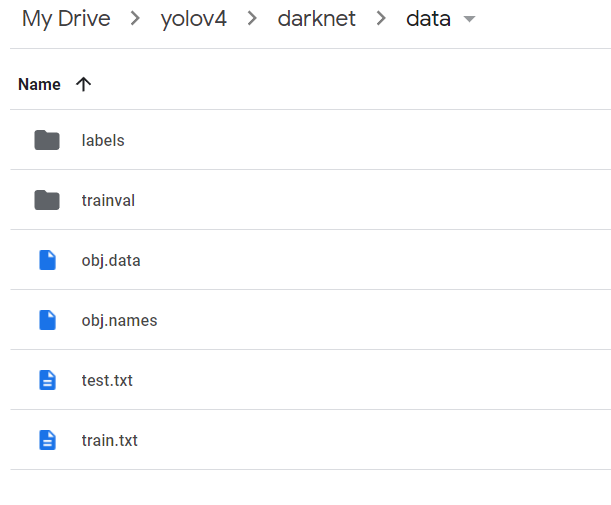

Also move the **yolov4-custom.cfg** file to the **darknet/cfg folder** as shown below 
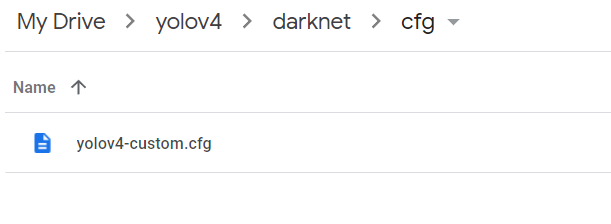

# Step 5
Modify the change runtime type to use GPU under the runtime tab in google colab

Next run the below code to enable the GPU, nvidia CUDA and OpenCV


In [ ]:
# change makefile to have GPU and OPENCV enabled
# also set CUDNN, CUDNN_HALF and LIBSO to 1

%cd darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

# Step 6
Build the darknet folder so that we can start training

In [ ]:
!make

# Step 7
Ideally we can start training the network now, but since the dataset is very big it will take a few days to complete training. To avoid this we can download pretrained weights and train on that.


In [ ]:
# Download the yolov4 pre-trained weights file
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

# Step 8
We can finally start training the model using pretrained weights with the following command

In [ ]:
# to train!!
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg yolov4.conv.137 -dont_show -map

Training usually takes around 24-36 hours. Colab will disconnect in the middle. If that happens you need not run the whole training model from the begenning, yolo saves the updated weights every hundred iterations in the backup folder (which we gave as yolov4/training). We can resume our training from there. But before that make sure you run Step 5 and Step 6 before the next command

In [ ]:
#to restart training your custom detector where you left off(using the weights that were saved last)

!./darknet detector train data/obj.data cfg/yolov4-custom.cfg /mydrive/yolov4/training/yolov4-custom_last.weights -dont_show -map

# Step 9
Once the model has been trained we can test it on the data we had in the test folder. Before that we need to create a file containing the path to the images we want to test on. Here we call it **test.txt**.
Run the following code to do that -

In [ ]:
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

files = glob('/content/drive/MyDrive/ROB535/test/*/*_image.jpg')
f= open("/content/drive/MyDrive/test.txt","w+")
for i in files:
  x = i.replace('drive', 'gdrive')
  x = x+"\n"
  f.write(x)
f.close()

Next we make changes to our custom cfg file.
*   change batch to equal 1
*   change subdivisions to equal 1

The code below does this for us-

In [ ]:
#set your custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=64/subdivisions=1/' yolov4-custom.cfg
%cd ..

Next we run the model on all the images that are on the test.txt file.

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg /mydrive/yolov4/training/yolov4-custom_best.weights -ext_output -dont_show -out result.json < /content/gdrive/MyDrive/test.txt

This saves our results in a file called **result.json**. Run the following code block to download the file.

In [ ]:
def download(path):
  from google.colab import files
  files.download(path)
  
download('result.json')

# Step 10
Run the json file through the matlab script provided here to generate the required csv file which can then be uploaded to kaggle!!